### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

### Import Datasets

In [2]:
df = pd.read_csv('combined_psf.csv', index_col=0)

### Label Encoding and Train-Test Split

In [3]:
# Label encoding
df['street'] = df['street'].astype('category')
street_dict = dict(zip(df['street'].cat.codes, df['street']))
df['street'] = df['street'].cat.codes

df['propertyType'] = df['propertyType'].astype('category')
property_dict = dict(zip(df['propertyType'].cat.codes, df['propertyType']))
df['propertyType'] = df['propertyType'].cat.codes

df['floor_range'] = df['floor_range'].astype('category')
floor_dict = dict(zip(df['floor_range'].cat.codes, df['floor_range']))
df['floor_range'] = df['floor_range'].cat.codes

In [4]:
# Train-Test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(df.drop('price_psf', axis=1),
                                                    df['price_psf'], 
                                                    test_size=0.2,
                                                    random_state=1)

### Summary of Results
*Goal: Low RMSE, Low MAE, R2 close to 1, High Adjusted R2, Low MAPE, Low SMAPE

Results:
1. Default Decision Tree 
    - training mse: 189.02824441466748, testing mse: 9974.394392547632
    - training rmse: 13.748754285922324, testing rmse: 99.8718899017518
    - training mae: 2.8413158146490267, testing mae: 46.692932553568916
    - training R2: 0.9992616802245956, testing R2: 0.9616051329794566
    - training adjusted R2: 0.9992615835650965, testing adjusted R2: 0.9615850181668125
    - training mape: 0.43643700325575846, testing mape: 6.376642229347042
    - training smape: 0.4346875396966903, testing smape: 6.297509091283353
2. Decision Tree with Randomized Search 
    - training mse: 2964.65569693096, testing mse: 9308.234737477758
    - training rmse: 54.44865192941842, testing rmse: 96.47919328786782
    - training mae: 26.272249263871053, testing mae: 45.829064691615265
    - training R2: 0.9884204398390978, testing R2: 0.9641694101038872
    - training adjusted R2: 0.9884189238638763, testing adjusted R2: 0.964150638698785
    - training mape: 3.500009927066034, testing mape: 6.0080009792694895
    - training smape: 3.4761947404453566, testing smape: 5.932191616543596
3. Default Random Forest 
    - training mse: 1364.8182164699824, testing mse: 6705.372489310907
    - training rmse: 36.94344619103614, testing rmse: 81.88633884422302
    - training mae: 16.851178048850457, testing mae: 40.091410091439506
    - training R2: 0.9946691972822781, testing R2: 0.9741887201449887
    - training adjusted R2: 0.9946684993831595, testing adjusted R2: 0.9741751977890417
    - training mape: 2.2672564545820224, testing mape: 5.380834300457535
    - training smape: 2.2509681078033563, testing smape: 5.307133344194216
4. Random Forest with Randomized Search (Best Result)
    - training mse: 990.4215441980541, testing mse: 6200.896231904542
    - training rmse: 31.470963509210424, testing rmse: 78.74576961275153
    - training mae: 15.22635240286614, testing mae: 38.478511464639766
    - training R2: 0.9961315420648787, testing R2: 0.9761306223854506
    - training adjusted R2: 0.996131035613313, testing adjusted R2: 0.976118117379029
    - training mape: 2.0698084175200955, testing mape: 5.185679325802893
    - training smape: 2.0573082142421377, testing smape: 5.112297751252848

### Define function for MAPE and sMAPE

In [5]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred.squeeze()-y_true.squeeze()) / (np.abs(y_true.squeeze()) + np.abs(y_pred.squeeze()))*100)

### Decision Tree

#### (a) Basic Decision Tree with Default Parameters

[ 393.05170345 1570.50529128  309.67709969 ... 1924.42197663  674.77010143
  379.77982775]
training mse: 189.02824441466748, testing mse: 9974.394392547632
training rmse: 13.748754285922324, testing rmse: 99.8718899017518
training mae: 2.8413158146490267, testing mae: 46.692932553568916
training R2: 0.9992616802245956, testing R2: 0.9616051329794566
training adjusted R2: 0.9992615835650965, testing adjusted R2: 0.9615850181668125
training mape: 0.43643700325575846, testing mape: 6.376642229347042
training smape: 0.4346875396966903, testing smape: 6.297509091283353


Text(0.5, 1.0, 'Residual plot')

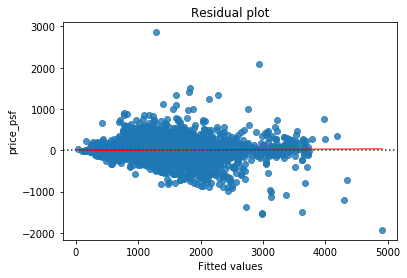

In [6]:
# train model
dt = tree.DecisionTreeRegressor()
dt.fit(x_train,y_train)

# make predictions on test set
y_pred_train = dt.predict(x_train)
y_pred = dt.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-dt.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-dt.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
sns.residplot(dt.predict(x_test).reshape(-1),y_test,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

#### (b) Decision Tree using Best Estimators from Randomized Search

In [7]:
params = {'min_samples_split': [7,12,15,20,25]}
rsearch_dt = RandomizedSearchCV(tree.DecisionTreeRegressor(random_state=42), 
                          params, 
                          scoring = 'r2',
                          verbose=1, 
                          cv=model_selection.KFold(5), 
                          n_jobs=-1)
rsearch_dt.fit(x_train, y_train)
print('best score:', rsearch_dt.best_score_)
print('best parameters: ', rsearch_dt.best_params_)
print('best estimators: ', rsearch_dt.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    7.3s finished


best score: 0.9598699027572739
best parameters:  {'min_samples_split': 12}
best estimators:  DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=12, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')


[ 351.41014396 1551.44044292  297.42510446 ... 1941.09935244  669.39563478
  380.92835545]
training mse: 2964.65569693096, testing mse: 9308.234737477758
training rmse: 54.44865192941842, testing rmse: 96.47919328786782
training mae: 26.272249263871053, testing mae: 45.829064691615265
training R2: 0.9884204398390978, testing R2: 0.9641694101038872
training adjusted R2: 0.9884189238638763, testing adjusted R2: 0.964150638698785
training mape: 3.500009927066034, testing mape: 6.0080009792694895
training smape: 3.4761947404453566, testing smape: 5.932191616543596


Text(0.5, 1.0, 'Residual plot')

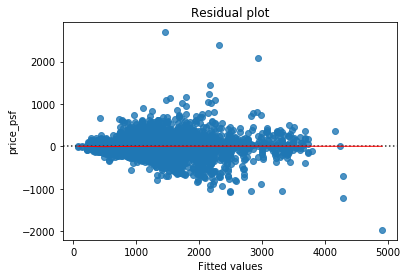

In [8]:
# make predictions on test set
y_pred_train = rsearch_dt.predict(x_train)
y_pred = rsearch_dt.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-rsearch_dt.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-rsearch_dt.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
sns.residplot(rsearch_dt.predict(x_test).reshape(-1),y_test,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

### Random Forest

#### (a) Basic Random Forest with Default Parameters

/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[ 358.97852952 1602.77304043  306.2928406  ... 2131.25550159  677.70388448
  386.89559495]
training mse: 1364.8182164699824, testing mse: 6705.372489310907
training rmse: 36.94344619103614, testing rmse: 81.88633884422302
training mae: 16.851178048850457, testing mae: 40.091410091439506
training R2: 0.9946691972822781, testing R2: 0.9741887201449887
training adjusted R2: 0.9946684993831595, testing adjusted R2: 0.9741751977890417
training mape: 2.2672564545820224, testing mape: 5.380834300457535
training smape: 2.2509681078033563, testing smape: 5.307133344194216


Text(0.5, 1.0, 'Residual plot')

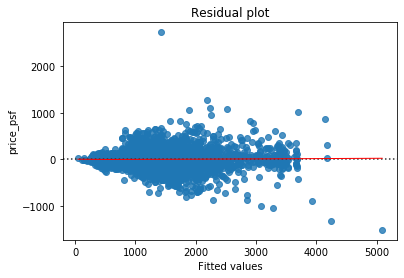

In [9]:
# train model
rforest = ensemble.RandomForestRegressor()
rforest.fit(x_train,y_train)

# make predictions on test set
y_pred_train = rforest.predict(x_train)
y_pred = rforest.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-rforest.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-rforest.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
sns.residplot(rforest.predict(x_test).reshape(-1),y_test,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

In [10]:
rforest.get_params(deep=True)

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### (b) Random Forest using Best Estimators from Randomized Search

In [11]:
params = {'n_estimators': [100,150,200,250]}
random_search_cv = RandomizedSearchCV(ensemble.RandomForestRegressor(random_state=42), 
                              params, 
                              scoring = 'r2', 
                              verbose=1, 
                              cv=model_selection.KFold(5),
                              n_jobs = -1)
random_search_cv.fit(x_train, y_train)
print('best score:', random_search_cv.best_score_)
print('best parameters: ', random_search_cv.best_params_)
print('best estimators: ', random_search_cv.best_estimator_)

/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 10.6min finished


best score: 0.9737738228546212
best parameters:  {'n_estimators': 250}
best estimators:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=250,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


[ 352.8851993  1577.31712255  303.25262924 ... 2084.58047859  671.09933326
  385.7207595 ]
training mse: 990.4215441980541, testing mse: 6200.896231904542
training rmse: 31.470963509210424, testing rmse: 78.74576961275153
training mae: 15.22635240286614, testing mae: 38.478511464639766
training R2: 0.9961315420648787, testing R2: 0.9761306223854506
training adjusted R2: 0.996131035613313, testing adjusted R2: 0.976118117379029
training mape: 2.0698084175200955, testing mape: 5.185679325802893
training smape: 2.0573082142421377, testing smape: 5.112297751252848


Text(0.5, 1.0, 'Residual plot')

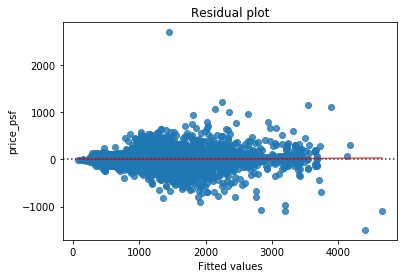

In [12]:
# make predictions on test set
y_pred_train = random_search_cv.predict(x_train)
y_pred = random_search_cv.predict(x_test)
print(y_pred)

# compute metrics 
train_mse = mean_squared_error(y_train,y_pred_train)
test_mse = mean_squared_error(y_test,y_pred)

train_mae = mean_absolute_error(y_train,y_pred_train)
test_mae = mean_absolute_error(y_test,y_pred)

train_r_squared = r2_score(y_train,y_pred_train)
test_r_squared = r2_score(y_test,y_pred)

train_adj_r_squared = 1 - (1-random_search_cv.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
test_adj_r_squared = 1 - (1-random_search_cv.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
test_mape = mean_absolute_percentage_error(y_test,y_pred)

train_smape = smape(y_train,y_pred_train)
test_smape = smape(y_test,y_pred)

print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# residual plot
sns.residplot(random_search_cv.predict(x_test).reshape(-1),y_test,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

In [13]:
random_search_cv.get_params(deep=True)

{'cv': KFold(n_splits=5, random_state=None, shuffle=False),
 'error_score': 'raise-deprecating',
 'estimator__bootstrap': True,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 'warn',
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimato

In [14]:
## test

In [15]:
# params = {'n_estimators': [10,20,50,100,150]}
# random_search_cv = RandomizedSearchCV(ensemble.RandomForestRegressor(random_state=42), 
#                               params, 
#                               scoring = 'r2', 
#                               verbose=1, 
#                               cv=model_selection.KFold(5),
#                               n_jobs = -1)
# random_search_cv.fit(x_train, y_train)
# print('best score:', random_search_cv.best_score_)
# print('best parameters: ', random_search_cv.best_params_)
# print('best estimators: ', random_search_cv.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/tohjiaxuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.4min finished


best score: 0.9737106344915678
best parameters:  {'n_estimators': 150}
best estimators:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)


[ 354.71577595 1575.36842219  303.06340756 ... 2093.31031265  670.49206082
  385.08452679]
training mse: 1003.4758058541013, testing mse: 6199.745196755613
training rmse: 31.677686245275257, testing rmse: 78.73846072127402
training mae: 15.283617563673337, testing mae: 38.48639343705022
training R2: 0.9960805538140816, testing R2: 0.97613505311475
training adjusted R2: 0.9960800406872256, testing adjusted R2: 0.9761225504295578
training mape: 2.0758581998429038, testing mape: 5.188204915936362
training smape: 2.063159944056599, testing smape: 5.1150922971637325


Text(0.5, 1.0, 'Residual plot')

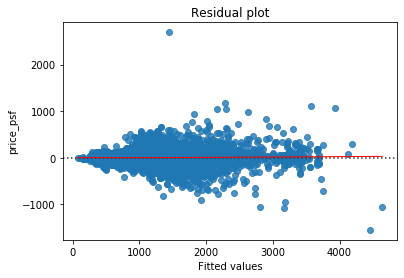

In [16]:
# # make predictions on test set
# y_pred_train = random_search_cv.predict(x_train)
# y_pred = random_search_cv.predict(x_test)
# print(y_pred)

# # compute metrics 
# train_mse = mean_squared_error(y_train,y_pred_train)
# test_mse = mean_squared_error(y_test,y_pred)

# train_mae = mean_absolute_error(y_train,y_pred_train)
# test_mae = mean_absolute_error(y_test,y_pred)

# train_r_squared = r2_score(y_train,y_pred_train)
# test_r_squared = r2_score(y_test,y_pred)

# train_adj_r_squared = 1 - (1-random_search_cv.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
# test_adj_r_squared = 1 - (1-random_search_cv.score(x_test, y_test))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)

# train_mape = mean_absolute_percentage_error(y_train,y_pred_train)
# test_mape = mean_absolute_percentage_error(y_test,y_pred)

# train_smape = smape(y_train,y_pred_train)
# test_smape = smape(y_test,y_pred)

# print("training mse: {}, testing mse: {}".format(train_mse, test_mse))
# print("training rmse: {}, testing rmse: {}".format(np.sqrt(train_mse), np.sqrt(test_mse)))
# print("training mae: {}, testing mae: {}".format(train_mae, test_mae))
# print("training R2: {}, testing R2: {}".format(train_r_squared, test_r_squared))
# print("training adjusted R2: {}, testing adjusted R2: {}".format(train_adj_r_squared, test_adj_r_squared))
# print("training mape: {}, testing mape: {}".format(train_mape, test_mape))
# print("training smape: {}, testing smape: {}".format(train_smape, test_smape))

# # residual plot
# sns.residplot(random_search_cv.predict(x_test).reshape(-1),y_test,lowess=True,
#                                   line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
# plt.xlabel("Fitted values")
# plt.title('Residual plot')